In [1]:
import sys
from basic_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.precision', 3)
cmap = 'tab20'
fs, lw, alp, loc, margin = (12,5), 5, 0.5, 'center left', (1, 0.5)
sl = 3 # to slice large lists in top / bottom chunks
# pd.describe_option()

Loading config.json


### General functions

In [2]:
freq_dist = lambda df, col, tail: df[col].tail(tail).value_counts(bins=12, normalize=True).sort_index()
shorten_name = lambda x: "".join([str.upper(z[:3]) for z in x])
roll_vol = lambda df, rw: (df.rolling(rw).std() * pow(252, 1/2))

# helper methods
def build_px_struct(data_dict, freq):
    dt = date if freq == '1d' else datetime
    dates = [dt.fromtimestamp(x) for x in data_dict['timestamp']]
    hist_pricing = data_dict['indicators']['quote'][0]
    H = hist_pricing['high']
    L = hist_pricing['low']
    O = hist_pricing['open']
    C = hist_pricing['close']
    V = hist_pricing['volume']
    price_dict = {'high': H,'low': L,'open': O,'close' : C, 'volume': V}
    df = pd.DataFrame(price_dict, index=dates)    
    return df

def get_rt_pricing(symbol, freq='1d', prange='10d', cols=None):
    data_dict = get_pricing(symbol, freq, prange)
    df = build_px_struct(data_dict, freq)
    cols = df.columns if cols is None else cols
    return df[cols].dropna()

def get_symbol_pricing(symbol, freq, cols=None):
    path = config['pricing_path'].format(freq)
    data_dict = json_load(path + json_ext.format(symbol))
    df = build_px_struct(data_dict, freq)
    cols = df.columns if cols is None else cols
    return df[cols].dropna()

def get_mults_pricing(symbols, freq, col='close'):
    group_pricing = pd.DataFrame()
    for n, t in enumerate(symbols):
        print("Getting pricing for {0}".format(t))
        sec_hp = get_symbol_pricing(t, freq,[col])
        sec_hp.rename(columns={col: t}, inplace=True)
        if n == 0: group_pricing = pd.DataFrame(sec_hp)
        else: group_pricing[t] = sec_hp
    return group_pricing

def apply_std_boundaries(df, col='close', window=30, stds=2):
    sma = df[col].rolling(window).mean()
    smastd = df[col].rolling(window).std()
    smaub = sma + smastd*stds
    smalb = sma - smastd*stds
    df['sma' + str(window)] = sma
    df['sma' + str(window) + 'ub'] = smaub
    df['sma' + str(window) + 'lb'] = smalb
    df['sma' + str(window) + 'bw'] = smastd*stds / sma
    return df

def get_ind_index(closepx, freq='1d', tail=60, name='^IND'):
    closepx = closepx.tail(tail)
    memb_count = len(symbols)
    eq_wgt = 1 / memb_count
    closepx.set_index(pd.DatetimeIndex(closepx.index), inplace=True)
    comp_indexed = (closepx.pct_change() + 1).cumprod()
    comp_indexed.iloc[0] = 1
    # comp_indexed.pct_change(), closepx.pct_change() # CHECK, should be the same
    comp_indexed[name] = (comp_indexed * eq_wgt).sum(axis=1)
    return comp_indexed

def to_index_form(df, name):
    dt_index = pd.DatetimeIndex(df.index)
    idx = pd.DataFrame((df.pct_change() + 1).cumprod().values, 
        index=dt_index, columns=[name])
    idx.iloc[0] = 1
    return idx

def beta(df):
    # first column is the market
    X = df.values[:, [0]]
    # prepend a column of ones for the intercept
    X = np.concatenate([np.ones_like(X), X], axis=1)
    # matrix algebra
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values[:, 1:])
    return pd.Series(b[1], df.columns[1:], name='Beta')

def get_statspc_dates(df, treshold):
    mask = df.abs() / df.std() > treshold
    return df[mask][(df[mask].sum(axis=1) != 0).values]

def eq_wgt_attribution(comp_idx, index_col, resample_period):
    rp_delta = comp_idx.sub(comp_idx[index_col], axis='rows').iloc[:,:-1]
    resampled = (rp_delta/len(rp_delta.columns)).resample(resample_period, level=0).sum()
    return resampled[resampled.iloc[-1].sort_values(ascending=False).index]

def rank_roll_perf(df, roll_window):
    ind_ranked = df.round(2).rank(axis=1)
    rolled_ranked = ind_ranked.rolling(roll_window).mean()
    show = rolled_ranked.iloc[-1].sort_values().index.tolist()
    return rolled_ranked[show]

def get_left_right(alist, sl):
    # mods large list into left / right chunks
    be = len(alist) // sl
    left, right = be + 1 if be * sl < len(alist) else be, be
    return left, right



In [3]:
# contextual information
symbol = 'VCYT'
market_etf = 'SPY'
freq, tail = '1d', 20 * 6
window, stds = 20, 1.75

dates = read_dates('quote') 
tgt_date = [dates[-1]] # last date saved in S3
# latest_quotes = load_csvs('quote_consol', tgt_date)
quotes = load_csvs('quote_consol', tgt_date)
profile = load_csvs('summary_detail', ['assetProfile'])
show = ['symbol','sector', 'industry']
industries = profile[show].sort_values(by='industry').industry.dropna().unique().tolist()
left, right = get_left_right(industries, sl)
sect_idx_ticker, ind_idx_ticker = '^SECT', '^IND'

Loading file quote/csv/2019-02-21
Loading file summary-categories/assetProfile


### Retrieve pricing

In [4]:
# TAKES LONG: all pricing loaded, should do only once
symbols_list = config['benchmarks'] + config['sectors'] + config['industries'] + config['companies'] + config['risk']
px_set = get_mults_pricing(symbols_list, freq, 'close')

Getting pricing for SPY
Getting pricing for QQQ
Getting pricing for DIA
Getting pricing for IWM
Getting pricing for IJR
Getting pricing for IJH
Getting pricing for FXI
Getting pricing for EEM
Getting pricing for ^DJI
Getting pricing for ^IXIC
Getting pricing for ^GSPC
Getting pricing for ^RUT
Getting pricing for XLB
Getting pricing for XLC
Getting pricing for XLE
Getting pricing for XLF
Getting pricing for XLI
Getting pricing for XLK
Getting pricing for XLP
Getting pricing for XLRE
Getting pricing for XLU
Getting pricing for XLV
Getting pricing for XLY
Getting pricing for XES
Getting pricing for SMH
Getting pricing for XHB
Getting pricing for XRT
Getting pricing for KIE
Getting pricing for XAR
Getting pricing for XBI
Getting pricing for XOP
Getting pricing for XME
Getting pricing for KBE
Getting pricing for KRE
Getting pricing for 0700.HK
Getting pricing for 1810.HK
Getting pricing for 3690.HK
Getting pricing for 9984.T
Getting pricing for A
Getting pricing for AAPL
Getting pricing for

ValueError: cannot reindex from a duplicate axis

### High level risk

(11.585, 13.648]    0.833
(13.648, 15.687]    0.708
(15.687, 17.725]    0.567
(17.725, 19.763]    0.400
(19.763, 21.802]    0.183
(21.802, 23.84]     0.133
(23.84, 25.878]     0.050
(25.878, 27.917]    0.050
(27.917, 29.955]    0.033
(29.955, 31.993]    0.008
(31.993, 34.032]    0.008
(34.032, 36.07]    -0.000
Name: close, dtype: float64

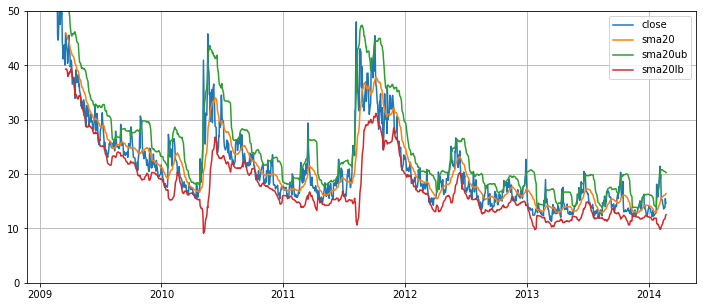

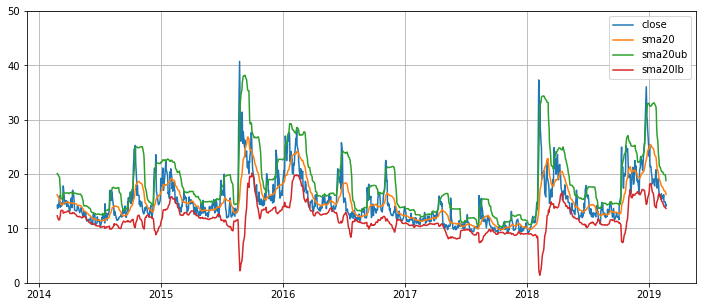

In [4]:
# Apply BB to VIX
symbol = '^VIX'
# sec_pricing = get_symbol_pricing(symbol, freq, ['open', 'low', 'high', 'close'])
secpx = get_symbol_pricing(symbol, freq)
show = ['close']
df = apply_std_boundaries(secpx, show, 20, 1.75)
smacols = [x for x in df.columns if 'sma' in x]
show = ['close'] + smacols

# historical frequency
freq_col = 'close' # show[-1]
left, right = get_left_right(df, 2)
df[show[:-1]].iloc[:left].plot(figsize=fs, ylim=[0, 50], grid=True)
df[show[:-1]].iloc[-right:].plot(figsize=fs, ylim=[0, 50], grid=True)
fd = freq_dist(df, freq_col, tail)
(1 - fd.cumsum()).round(3)
# pd.DataFrame(fd).plot.barh(label='index')

In [5]:
# Historical analysis when portfolio insurance is cheap
# When does vol crosses [low] bound at [x] std
show = ['close','sma20ub']
dates = df[df.close < df.sma20lb].index.tolist()
abovesma = pd.DataFrame(
    [{'year':x.year, 'month':x.month, 'day':x.day} for x in dates])
abovesma.pivot_table(
    index='year', columns='month', aggfunc='count')\
    .replace(np.nan, '')

day                                 
month  1  2  3  4  5  6  7  8  9  10 11 12
year                                      
2009             3  4  3                  
2010    2  1     2              2  3      
2011    1        3        1        1  1  2
2012    2  1  3        3     1        2   
2013                         2        2   
2014                4  2              2   
2015             1     1           3      
2016          3     2        1            
2017                                  1   
2018             1  3        3        1   
2019       4

In [6]:
# Last few dates the VIX is below trend
abovesma.tail(5)

,day,month,year
72,7,11,2018
73,1,2,2019
74,4,2,2019
75,5,2,2019
76,6,2,2019


### Sector overview

In [350]:
# Pull sector ETFs for relative performance
symbols = config["sectors"]
closepx = px_set[symbols]
# openpx = get_mults_pricing(symbols, freq, 'open')
# ((closepx - openpx) / openpx * 100).std().sort_values().plot.barh()

comp_idx = get_ind_index(px_set[symbols], freq, tail, ind_idx_ticker)
SPY = get_symbol_pricing('SPY', freq, 'close').tail(tail)
comp_idx.drop(ind_idx_ticker, axis=1, inplace=True)
comp_idx['SPY'] = to_index_form(SPY, 'SPY')

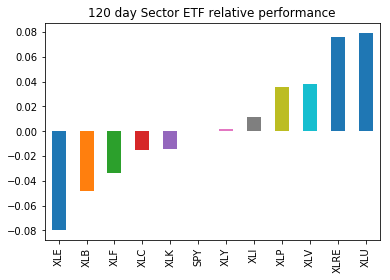

In [351]:
# Sector relative performance
cumulative = comp_idx.iloc[-1]
last_delta = cumulative - cumulative['SPY']
ctitle = '{} day Sector ETF relative performance'.format(tail)
last_delta.sort_values(ascending=True).plot(
    kind='bar', label='index', title=ctitle)

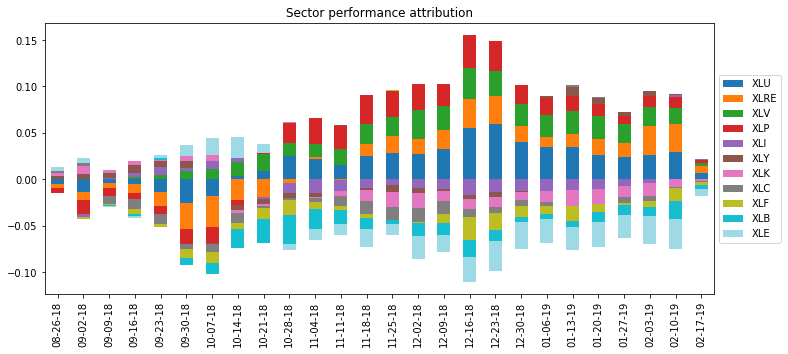

In [352]:
# Sector performance attribution
resampled = eq_wgt_attribution(comp_idx, 'SPY', 'W')
ctitle = 'Sector performance attribution'
ax = resampled.plot(kind='bar', stacked=True, 
                    figsize=(12,5), colormap=cmap, title=ctitle)
ax.set_xticklabels(resampled.index.strftime('%m-%d-%y'));
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

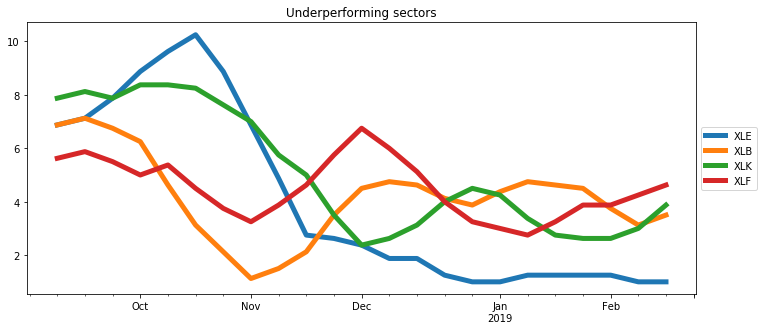

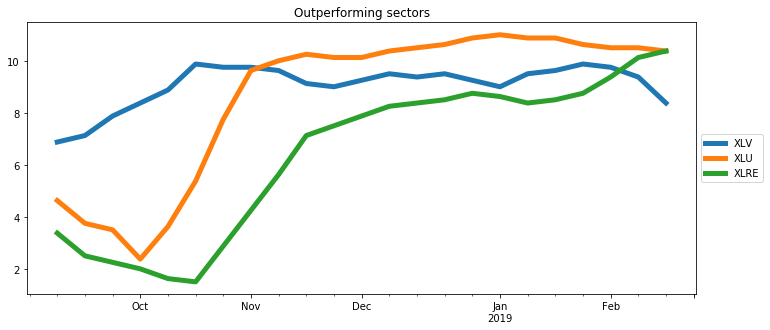

In [353]:
# Sector performance rankings
roll_window = 4
rank_rolled = rank_roll_perf(resampled, roll_window)
left, right = get_left_right(rank_rolled.columns, sl)

ctitle = 'Underperforming sectors'
rank_rolled.iloc[:,:left].plot(figsize=fs, linewidth=lw, title=ctitle)\
    .legend(loc=loc, bbox_to_anchor=margin)
ctitle = 'Outperforming sectors'
rank_rolled.iloc[:,-right:].plot(figsize=fs, linewidth=lw, title=ctitle)\
    .legend(loc=loc, bbox_to_anchor=margin);

### Industry overview

In [354]:
# Calculate industry indices
ind_indices = pd.DataFrame()
for n, ind in enumerate(industries):
    ind_id = shorten_name(ind.split(" "))
    symbols = profile[profile.industry == ind].symbol.tolist()
    comp_idx = get_ind_index(px_set[symbols], '1d', tail, ind_id)
    ind_idx = comp_idx.iloc[:, -1:]
    if n == 0: ind_indices = pd.DataFrame(ind_idx)
    else: ind_indices[ind_id] = ind_idx

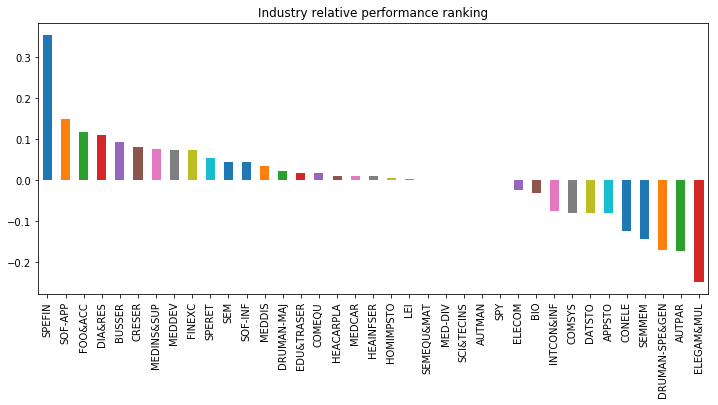

In [355]:
# Industry performance relative ranking
SPY = get_symbol_pricing('SPY', freq, 'close').tail(tail)
ind_indices['SPY'] = to_index_form(SPY, 'SPY')
cumulative = ind_indices.iloc[-1]
last_delta = cumulative - cumulative['SPY']
# last_delta = cumulative
ctitle = 'Industry relative performance ranking'
last_delta.sort_values(ascending=False).plot(
    kind='bar', label='index', figsize=(12,5), title=ctitle);

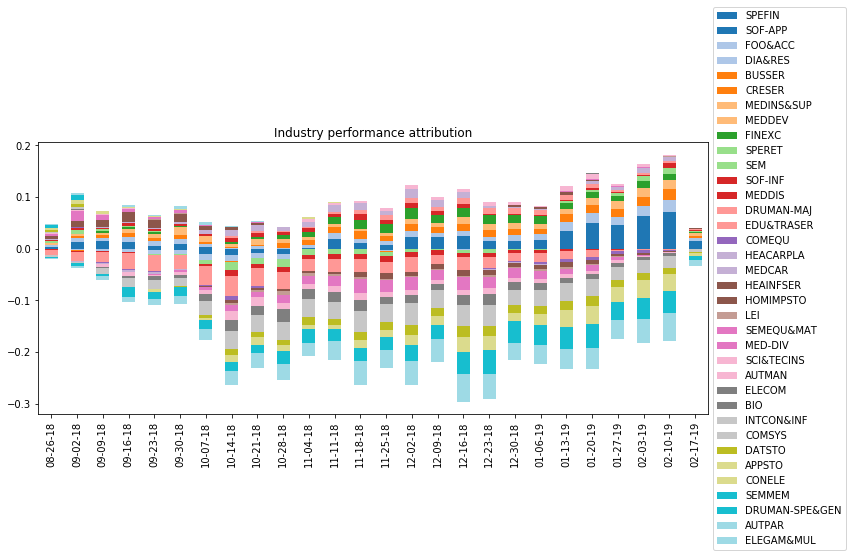

In [356]:
# Industry performance attribution
resampled = eq_wgt_attribution(ind_indices, 'SPY', 'W')
ctitle = 'Industry performance attribution'
ax = resampled.plot(kind='bar', stacked=True, 
                    figsize=(12,5), colormap=cmap, title=ctitle)
ax.set_xticklabels(resampled.index.strftime('%m-%d-%y'));
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

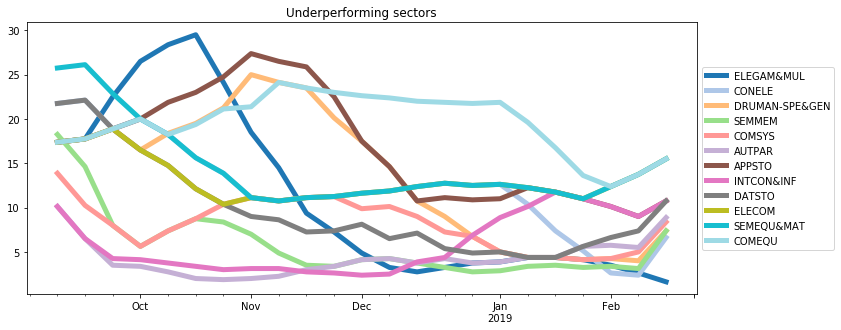

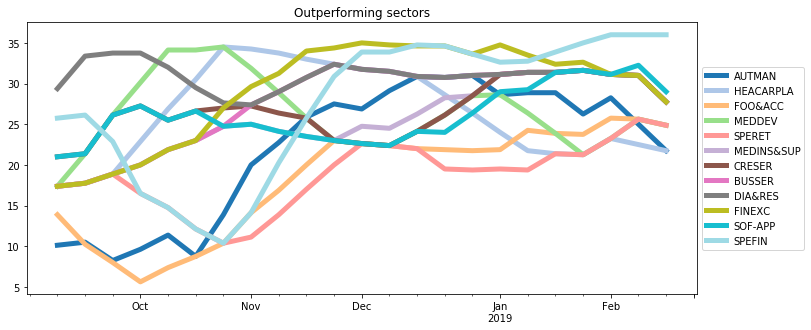

In [357]:
# Industry performance rankings
resampled = eq_wgt_attribution(ind_indices, 'SPY', 'W')
rank_rolled = rank_roll_perf(resampled, 4)
left, right = get_left_right(rank_rolled.columns, sl)

ctitle = 'Underperforming sectors'
rank_rolled.iloc[:,:left].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);
ctitle = 'Outperforming sectors'
rank_rolled.iloc[:,-right:].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);

### Industry deep dive

In [358]:
tgt_industry = industries[29]
symbols = profile[profile.industry == tgt_industry].symbol.tolist()
ind_id = shorten_name(tgt_industry.split(" "))
print(ind_id, symbols)
[(shorten_name(ind[1].split(" ")), ind) for ind in enumerate(industries)]

SEMEQU&MAT ['AMAT', 'BRKS', 'IPGP', 'KLAC', 'OLED', 'TER']


[('APPSTO', (0, 'Apparel Stores')),
 ('AUTMAN', (1, 'Auto Manufacturers')),
 ('AUTPAR', (2, 'Auto Parts')),
 ('BIO', (3, 'Biotechnology')),
 ('BUSSER', (4, 'Business Services')),
 ('COMEQU', (5, 'Communication Equipment')),
 ('COMSYS', (6, 'Computer Systems')),
 ('CONELE', (7, 'Consumer Electronics')),
 ('CRESER', (8, 'Credit Services')),
 ('DATSTO', (9, 'Data Storage')),
 ('DIA&RES', (10, 'Diagnostics & Research')),
 ('DRUMAN-MAJ', (11, 'Drug Manufacturers - Major')),
 ('DRUMAN-SPE&GEN', (12, 'Drug Manufacturers - Specialty & Generic')),
 ('EDU&TRASER', (13, 'Education & Training Services')),
 ('ELECOM', (14, 'Electronic Components')),
 ('ELEGAM&MUL', (15, 'Electronic Gaming & Multimedia')),
 ('FINEXC', (16, 'Financial Exchanges')),
 ('FOO&ACC', (17, 'Footwear & Accessories')),
 ('HEACARPLA', (18, 'Health Care Plans')),
 ('HEAINFSER', (19, 'Health Information Services')),
 ('HOMIMPSTO', (20, 'Home Improvement Stores')),
 ('INTCON&INF', (21, 'Internet Content & Information')),
 ('LEI',

Semiconductor Equipment & Materials analysis for 120 days


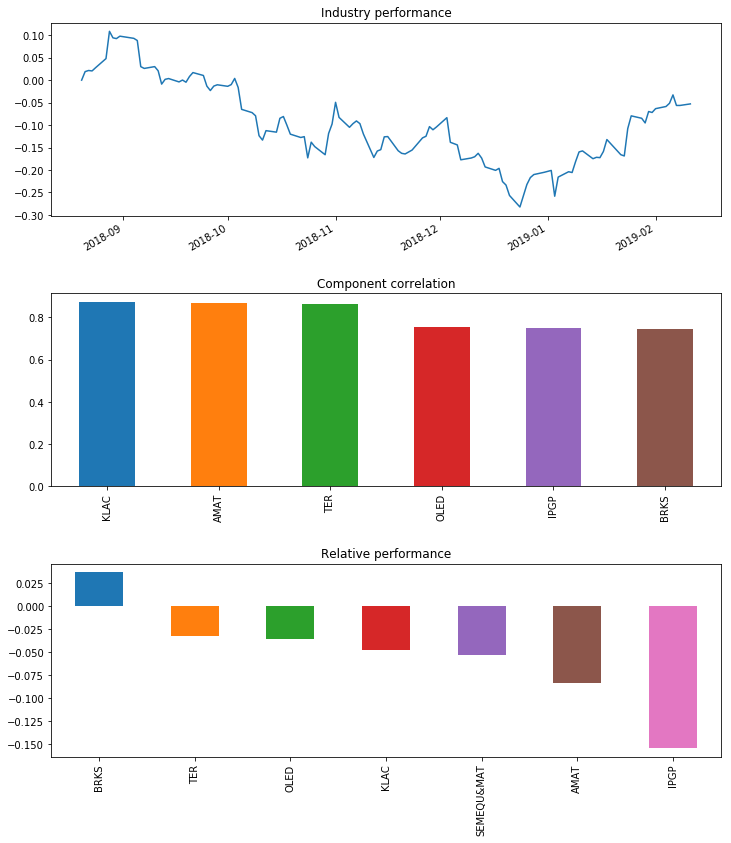

In [359]:
# Industry overview charts
comp_idx = get_ind_index(px_set[symbols], '1d', tail, ind_id)
fig, axs = plt.subplots(ncols=1, nrows=3, constrained_layout=False, figsize=(12,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

print('{} analysis for {} days'.format(tgt_industry, tail))
(comp_idx[ind_id] - 1).plot(
    ax=axs[0], title='Industry performance');

comp_idx.pct_change().corr()[ind_id].iloc[:-1].sort_values(ascending=False).plot(
    kind='bar', ax=axs[1], title='Component correlation');

(comp_idx.iloc[-1].sort_values(ascending=False) - 1).plot(
    kind='bar', ax=axs[2], title='Relative performance');

plt.show()

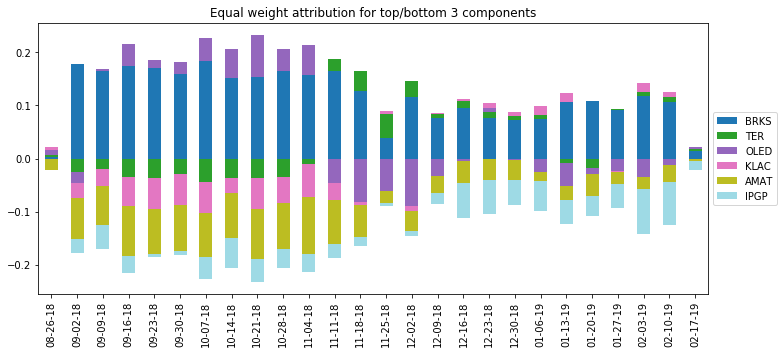

In [361]:
# Industry components performance attribution
resampled = eq_wgt_attribution(comp_idx, ind_id, 'W')
left, right = get_left_right(resampled.columns, 2)
show = resampled.columns[:(left)].tolist() + resampled.columns[-right:].tolist()
ctitle = 'Equal weight attribution for top/bottom {} components'.format(left, ind_id)
ax = resampled[show].plot(
    colormap=cmap, kind='bar', stacked=True, figsize=(12,5), title=ctitle)
ax.set_xticklabels(resampled.index.strftime('%m-%d-%y'));
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

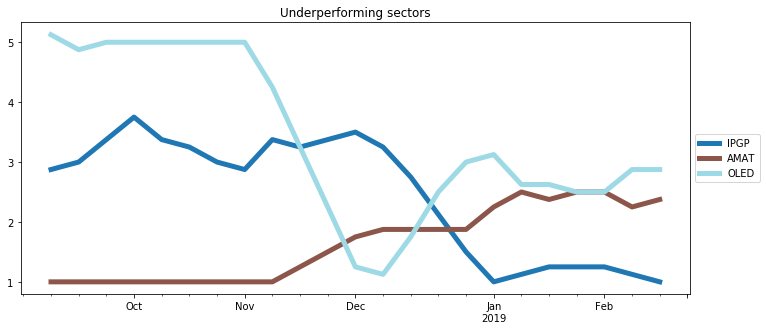

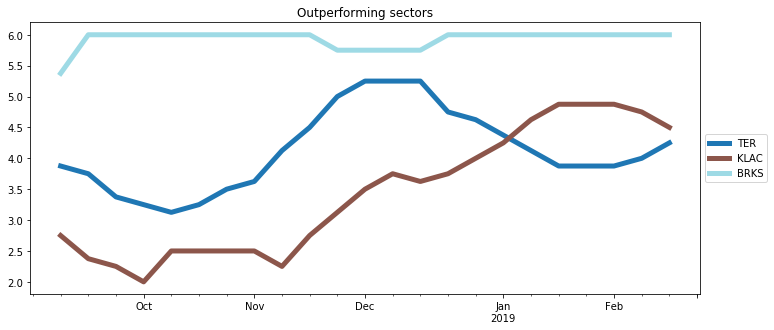

In [362]:
# Industry components performance ranking
rank_rolled = rank_roll_perf(resampled, 4)
ctitle = 'Underperforming sectors'
rank_rolled.iloc[:,:left].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);
ctitle = 'Outperforming sectors'
rank_rolled.iloc[:,-right:].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);

### Company relative to industry, sector and market performance
What's a statistically significant move?<br>
De-correlate vs. industry, sector, and market<br>
List key dates<br>
Create function to highlight relevant idiosincratic behaviour<br>

In [376]:
row = profile[profile.symbol == symbol]
sec_sector, sec_industry = row.iloc[0].sector, row.iloc[0].industry
sec_sector, sec_industry

('Healthcare', 'Biotechnology')

In [377]:
sec_index = to_index_form(
    get_symbol_pricing(symbol, freq, 'close').tail(tail),
    symbol)

symbols = profile[profile.industry == sec_industry].symbol.tolist()
industry_index = get_ind_index(
    px_set[symbols], '1d', tail, ind_idx_ticker)[[ind_idx_ticker]]

symbols = profile[profile.sector == sec_sector].symbol.tolist()
sector_index = get_ind_index(
    px_set[symbols], '1d', tail, sect_idx_ticker)[[sect_idx_ticker]]

market_index = to_index_form(
    get_symbol_pricing(market_etf, freq, 'close').tail(tail),
    market_etf)

index_df = pd.DataFrame()
index_df = index_df.append(sec_index)
index_df[ind_idx_ticker] = industry_index
index_df[sect_idx_ticker] = sector_index
index_df[market_etf] = market_index

In [378]:
index_df_pc = index_df.pct_change().iloc[1:]
print('{} days SPY beta'.format(len(index_df_pc)))
beta(index_df_pc[[market_etf,symbol,ind_idx_ticker,sect_idx_ticker]])

119 days SPY beta


VCYT     1.512
^IND     1.384
^SECT    1.112
Name: Beta, dtype: float64

20 days rolling volatility


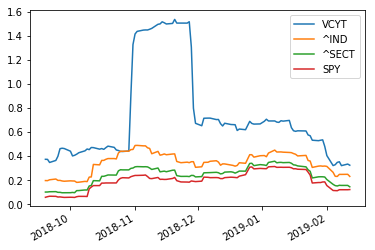

In [379]:
roll_window = 20
roll_vol_df = roll_vol(index_df_pc, roll_window)
print('{} days rolling volatility'.format(roll_window))
roll_vol_df.plot();

In [380]:
print('{} days correlation matrix'.format(len(index_df_pc)))
index_df_pc.corr()

119 days correlation matrix


,VCYT,^IND,^SECT,SPY
VCYT,1.000,0.380,0.405,0.384
^IND,0.380,1.000,0.937,0.810
^SECT,0.405,0.937,1.000,0.919
SPY,0.384,0.810,0.919,1.000


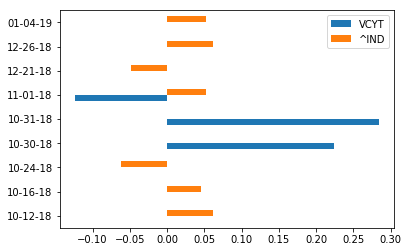

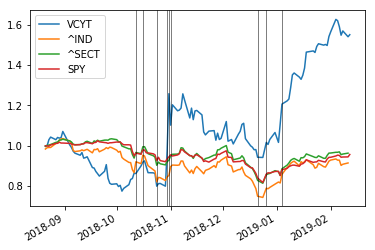

,VCYT,^IND
2018-10-12,NaN,0.062
2018-10-16,NaN,0.046
2018-10-24,NaN,-0.062
2018-10-30,0.225,NaN
2018-10-31,0.285,NaN
2018-11-01,-0.124,0.052
2018-12-21,NaN,-0.048
2018-12-26,NaN,0.062
2019-01-04,NaN,0.052


In [381]:
# show statistical significant moves for further key factors study
treshold = 2
statspc_df = get_statspc_dates(index_df_pc, treshold)
show = statspc_df.columns[:2]
filtered = statspc_df[statspc_df[show].sum(axis=1).abs() > 0][show]
ax = filtered.plot(kind='barh')
ax.set_yticklabels(filtered.index.strftime('%m-%d-%y'))
index_df.plot()
for d in filtered.index: plt.axvline(x=d, c='k', linewidth=0.5)

plt.show()
filtered

### Single security pricing, all fields

In [382]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.tail(5)

,high,low,open,close,volume
2019-02-06,19.440,18.30,19.12,18.77,561300
2019-02-07,18.650,17.96,18.61,18.27,339100
2019-02-08,18.625,17.95,17.96,18.52,256800
2019-02-11,18.510,17.87,18.47,18.18,390200
2019-02-12,18.430,17.98,18.13,18.30,325186


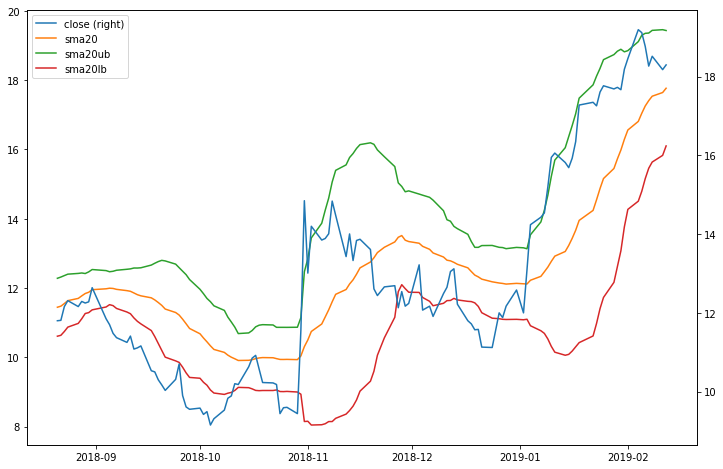

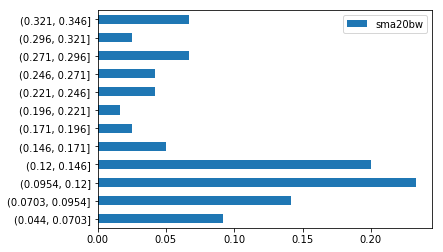

In [383]:
df = apply_std_boundaries(secpx, 'close', window, stds)
smacols = [x for x in df.columns if 'sma' in x]
show = ['close'] + smacols

df[show[:-1]].tail(tail).plot(secondary_y=freq_col, figsize=(12,8))

freq_col = 'sma' + str(window) + 'bw'
fd = freq_dist(df, freq_col, tail)
fd
pd.DataFrame(fd).plot.barh(label='index')

In [384]:
# Retrieves real-time pricing
# prange = '10y'
# secpx = get_rt_pricing(symbol, freq, prange)
# secpx.tail(5)

### Long exposure correlations

In [385]:
long_symbols = ['1810.HK', '9984.T', 'BABA', 'FB', 'GOOG', 'XOP']
nbr_pos = len(long_symbols)
# long_weights = [1/nbr_pos for x in long_symbols]
long_weights = [10.3, 3.7, 60.4, 22.3, 8.4, 3.18]
long_wv = np.array(long_weights) / 100

In [386]:
long_px = px_set[
    long_symbols + \
    config['benchmarks'] + \
    config['sectors']
    ].tail(tail)

# corr_mtrx = long_px.pct_change().corr()
corr_mtrx = long_px.pct_change().corr()
cov_mtrx = long_px.pct_change().cov() * 252

port_corr_mtrx = corr_mtrx.iloc[:nbr_pos, :nbr_pos]
port_cov_mtrx = cov_mtrx.iloc[:nbr_pos, :nbr_pos]
# tri_corr_mtrx = (port_corr_mtrx * np.tri(nbr_pos,nbr_pos, -1))
# cross_corr = np.dot(long_wv.T, np.dot(tri_corr_mtrx, long_wv))

cross_corr = np.dot(long_wv.T, np.dot(port_corr_mtrx, long_wv))
cross_vol = np.sqrt(np.dot(long_wv.T, np.dot(port_cov_mtrx, long_wv)))
ctitle = 'Portfolio {0} correlation {1} annualized volatility'.format(
    round(cross_corr,2), round(cross_vol,2))
print(ctitle)
port_corr_mtrx

Portfolio 0.76 correlation 0.35 annualized volatility


,1810.HK,9984.T,BABA,FB,GOOG,XOP
1810.HK,1.000,0.106,0.144,-0.104,-0.042,-0.078
9984.T,0.106,1.000,0.277,0.161,0.094,0.239
BABA,0.144,0.277,1.000,0.605,0.731,0.560
FB,-0.104,0.161,0.605,1.000,0.754,0.498
GOOG,-0.042,0.094,0.731,0.754,1.000,0.626
XOP,-0.078,0.239,0.560,0.498,0.626,1.000


In [391]:
top_corr_items = 3
corr_mtrx_bench = corr_mtrx.loc[long_symbols].T.iloc[nbr_pos:]
best_pairs = [(x, corr_mtrx_bench[corr_mtrx_bench[x] < 1][x].sort_values(ascending=False).index.tolist()[:top_corr_items]) for x in long_symbols]
best_pairs, corr_mtrx_bench

([('1810.HK', ['FXI', 'EEM', 'XLU']),
  ('9984.T', ['IJH', 'IWM', '^RUT']),
  ('BABA', ['EEM', 'FXI', '^IXIC']),
  ('FB', ['XLC', 'QQQ', '^IXIC']),
  ('GOOG', ['QQQ', 'XLC', '^IXIC']),
  ('XOP', ['XLE', '^GSPC', 'SPY'])],
        1810.HK  9984.T   BABA     FB   GOOG    XOP
 SPY     -0.046   0.269  0.672  0.669  0.834  0.772
 QQQ     -0.046   0.242  0.748  0.750  0.908  0.725
 DIA     -0.046   0.265  0.644  0.595  0.794  0.755
 IWM     -0.056   0.308  0.676  0.659  0.765  0.756
 IJR     -0.045   0.294  0.647  0.634  0.735  0.732
 IJH     -0.022   0.314  0.654  0.604  0.735  0.772
 FXI      0.189   0.162  0.815  0.502  0.669  0.556
 EEM      0.181   0.185  0.819  0.533  0.716  0.621
 ^DJI    -0.041   0.269  0.646  0.585  0.790  0.760
 ^IXIC   -0.047   0.253  0.756  0.745  0.898  0.741
 ^GSPC   -0.036   0.271  0.680  0.666  0.837  0.775
 ^RUT    -0.063   0.302  0.673  0.654  0.763  0.756
 XLB      0.006   0.277  0.622  0.485  0.676  0.683
 XLC     -0.075   0.176  0.704  0.854  0.899  0.67

In [392]:
cols = []; [cols.extend(y) for x, y in best_pairs]
cols = list(set(cols))
port_exp = pd.DataFrame([], index=long_symbols, columns=cols)
# port_exp.loc['FB', ['XLU','FXI']] = [1, 2]
for x, y in best_pairs: port_exp.loc[x, y] = corr_mtrx_bench.T.loc[x, y]
port_exp.replace(np.nan, '')

,IJH,SPY,IWM,^RUT,XLE,XLU,QQQ,XLC,^GSPC,EEM,^IXIC,FXI
1810.HK,,,,,,0.142,,,,0.181,,0.189
9984.T,0.314,,0.308,0.302,,,,,,,,
BABA,,,,,,,,,,0.819,0.756,0.815
FB,,,,,,,0.75,0.854,,,0.745,
GOOG,,,,,,,0.908,0.899,,,0.898,
XOP,,0.772,,,0.943,,,,0.775,,,


In [393]:
# portfolio greatest exposure
pd.Series(
    np.dot(port_exp.replace(np.nan, 0).T, long_wv.T), index=cols)\
    .sort_values(ascending=False)

^IXIC    0.698
EEM      0.513
FXI      0.512
XLC      0.266
QQQ      0.244
XLE      0.030
^GSPC    0.025
SPY      0.025
XLU      0.015
IJH      0.012
IWM      0.011
^RUT     0.011
dtype: float64

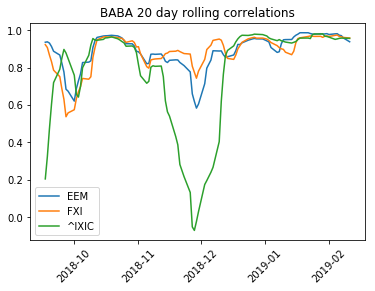

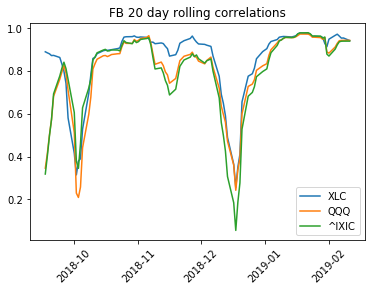

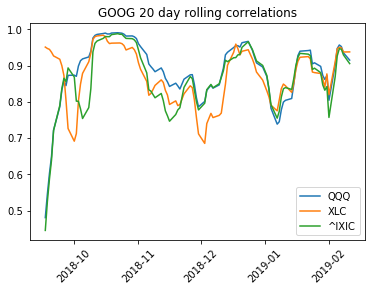

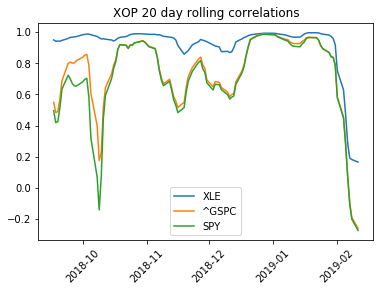

In [394]:
# Rolling correlation
roll_window = 20
missing_px = (long_px[long_symbols].count() < len(long_px[long_symbols])).tolist()
items = [best_pairs[x] for x in range(len(missing_px)) 
         if not missing_px[x]]
for x, y in items:
    title = '{} {} day rolling correlations'.format(x, roll_window)
    long_px[x]\
        .rolling(roll_window).corr(long_px[y])\
        .plot(title=title, rot=45)
# long_px.index.astype(date)

### Benchmark option pricing

In [395]:
options = load_csvs('option_consol', tgt_date)
cols_to_date = ['expiration', 'lastTradeDate', 'storeDate']
for c in cols_to_date: options[c] = options[c].apply(lambda x: datetime.fromtimestamp(x))
options.info()
# options.iloc[3]

Loading file option/csv/2019-02-12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17023 entries, 0 to 17022
Data columns (total 18 columns):
ask                  17023 non-null float64
bid                  17023 non-null float64
change               17023 non-null float64
contractSize         17023 non-null object
contractSymbol       17023 non-null object
currency             17012 non-null object
expiration           17023 non-null datetime64[ns]
impliedVolatility    17023 non-null float64
inTheMoney           17023 non-null bool
lastPrice            17023 non-null float64
lastTradeDate        17023 non-null datetime64[ns]
openInterest         17023 non-null float64
percentChange        17023 non-null float64
strike               17023 non-null float64
volume               17023 non-null float64
underlyingSymbol     17023 non-null object
storeDate            17023 non-null datetime64[ns]
type                 17023 non-null object
dtypes: bool(1), datetime64[ns](3), float64(9), obj

In [272]:
# find expirations with more than 90 days
def option_IV_atm(options, symbol, calDaysOut, minVolume, optnType, nbrStrikes):
    symbols = config['benchmarks'] + config['sectors']
    next_dt = np.datetime64(datetime.today() + pd.Timedelta(calDaysOut, unit='d'))
    uniq_expirations = options.expiration.sort_values().unique()
    tgt_expirations = uniq_expirations[uniq_expirations > next_dt]
    mask = (options.underlyingSymbol.isin(symbols)) &\
        (options.volume > minVolume) &\
        options.expiration.isin(tgt_expirations) &\
        (options.type == optnType)
    subset = options[mask]
    last_price = px_set[symbols].iloc[-1][symbol]
    contracts = subset[subset.underlyingSymbol == symbol]
#     atm_contract = (contracts.strike / last_price - 1).abs().idxmin()
    atm_contract = (contracts.strike / last_price - 1).abs().\
        sort_values().index[:nbrStrikes]
    return contracts.loc[atm_contract].sort_values(by='strike')

In [280]:
# shows implied volatility for all benchmarks
symbols = config['benchmarks'] + config['sectors']
b_IVs = pd.DataFrame()
for s in symbols:
#     print('Current price for {}: {}'.format(s, px_set[s].iloc[-1]))
    b_IVs = b_IVs.append(option_IV_atm(options, s, 90, 50, 'put', 1))
show = ['underlyingSymbol', 'expiration', 
        'strike', 'impliedVolatility', 
        'openInterest', 'volume','lastTradeDate']
# b_IVs[show].plot(kind='bar', x=show[0], y=show[1])
b_IVs[show].sort_values(by='expiration')

,underlyingSymbol,expiration,strike,impliedVolatility,openInterest,volume,lastTradeDate
9465,IJR,2019-05-16 17:00:00,77.0,0.170,40.0,86.0,2018-12-24 07:22:02
9247,FXI,2019-05-16 17:00:00,43.0,0.182,597.0,207.0,2019-02-05 12:53:04
11804,SPY,2019-06-20 17:00:00,271.0,0.150,1581.0,96.0,2019-02-12 08:00:24
14004,XLP,2019-06-20 17:00:00,53.0,0.142,371.0,200.0,2019-02-11 12:29:19
13658,XLI,2019-06-20 17:00:00,74.0,0.171,550.0,387.0,2019-02-04 12:55:57
13438,XLF,2019-06-20 17:00:00,25.0,0.185,32658.0,130.0,2019-02-12 08:27:08
12961,XLC,2019-06-20 17:00:00,35.0,0.313,72.0,100.0,2019-02-04 11:38:00
14585,XLY,2019-06-20 17:00:00,109.0,0.165,118.0,79.0,2019-02-12 07:56:45
9923,IWM,2019-06-20 17:00:00,151.0,0.168,800.0,263.0,2019-02-12 08:01:27
10700,QQQ,2019-06-20 17:00:00,168.0,0.183,8054.0,135.0,2019-02-12 08:06:26


In [281]:
# issue here is that rows could have diff. expirations
# shows mutiple implied volatility for one benchmark
symbol = 'XLK'
contract_list = option_IV_atm(options, symbol, 90, 50, 'put', 5)
contract_list[show].sort_values(by='expiration')

,underlyingSymbol,expiration,strike,impliedVolatility,openInterest,volume,lastTradeDate
13845,XLK,2019-06-20 17:00:00,72.0,0.164,995.0,876.0,2019-01-30 12:27:00
13882,XLK,2020-01-16 16:00:00,56.0,0.241,438.0,400.0,2019-01-28 07:09:30
13892,XLK,2020-01-16 16:00:00,66.0,0.196,245.0,282.0,2019-02-08 11:56:31
13918,XLK,2021-01-14 16:00:00,65.0,0.197,1455.0,350.0,2019-02-08 12:24:10
13922,XLK,2021-01-14 16:00:00,69.0,0.185,77.0,75.0,2018-11-08 11:39:21


In [ ]:
# PENDING: shows historical implied volatility for one benchmark
symbol = 'SPY'
b_IVs = pd.DataFrame()
for d in [dates[-20:]]:
    options = load_csvs('option_consol', d)
    cols_to_date = ['expiration', 'lastTradeDate', 'storeDate']
    for c in cols_to_date: 
        options[c] = options[c].apply(lambda x: datetime.fromtimestamp(x))
    option_IV_atm(options, symbol, 60, 50, 'put', 1)
b_IVs[show]

### Other functions

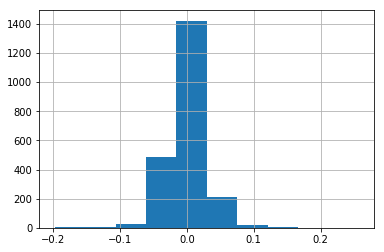

In [2046]:
df['hlSpread'] = (df['high'] - df['low']) / df['open']
df['coSpread'] = (df['close'] - df['open']) / df['open']
df['1mFwdRet'] = df['close'].shift(-20) / df['close'] - 1
df.coSpread.hist()
# df[df.coSpread < -0.075]

In [131]:
path = config['pricing_path'].format('1d')
data_dict = json_load(path + json_ext.format(symbol))
print(data_dict.keys())
data_dict['meta']
dates = [datetime.fromtimestamp(x) for x in data_dict['timestamp']]
indicators_quote_0 = data_dict['indicators']['quote'][0]
H = indicators_quote_0['high']
L = indicators_quote_0['low']
O = indicators_quote_0['open']
C = indicators_quote_0['close']
V = indicators_quote_0['volume']

dict_keys(['meta', 'timestamp', 'indicators'])


In [36]:
price_dict = {'high': H,'low': L,'open': O,'close' : C, 'volume': V}
df = pd.DataFrame(price_dict, index=dates)

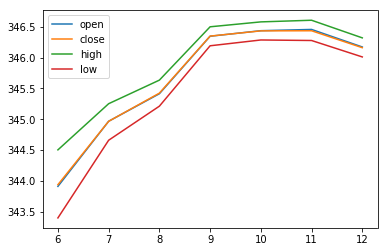

In [18]:
fields = ['open', 'close', 'high', 'low']
# fields = ['volume']
tgt_df = df[fields]
tgt_df.groupby(tgt_df.index.hour).mean().plot()
# tgt_df.plot()